# Vehicle Number Plate Analysis with Region of Interest (Dumb Method)

This notebook demonstrates how to analyze and extract information from vehicle number plate images using the <b>EasyOCR</b> library by leveraging the <b>Region of Interest</b> (without involving any deep learning).

To get started, you must have the following requirements installed:

1. `opencv-python` - the official Python implementation of the OpenCV library
2. `easyocr` - to extract information from number plates
3. `numpy` - for loading images as arrays
4. `matplotlib` - for displaying results graphically
5. `notebook` - to run this notebook in a Jupyter server

It is recommended to have a virtual environment to isolate these requirements from the rest of your system. This can be done using Python's `virtualenv` package.

First, open a <b>Terminal</b> (<b>Command Prompt</b> on Windows) in the same folder as this notebook and create a virtual environment:

```shell
python3 -m venv env
```

Next, activate the virtual environment. For Windows users:

```shell
.\env\Scripts\activate
```

For Linux and MacOS users:

```shell
source env/bin/activate
```

Now you can safely install the above requirements in your virtual environment:

```shell
pip install opencv-python easyocr numpy matplotlib notebook
```

After installation is complete, launch the Jupyter server to edit this notebook:

```shell
jupyter notebook
```

## Getting Started

The following imports are necessary to work with this notebook:

In [6]:
# imports

import cv2
import easyocr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Region of Interest

In image processing, a <b>Region of Interest</b> (ROI) can be defined as a specific area or portion of an image that must be selected for further analysis. Selecting an ROI is typically based on the relevance of the specific area to our requirement.

For example, consider the following image:

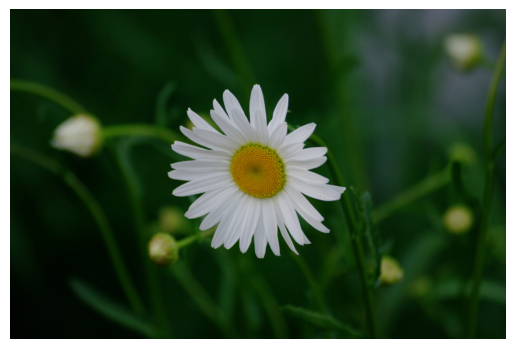

In [7]:
# load example image from disk
img = mpimg.imread("flower.jpg")

# display loaded image
%matplotlib inline
plt.imshow(img)
plt.axis("off")
plt.show()

Here, the portion of the image where the leaf is present can be selected as the ROI for an application where we must find out the type of plant based on the appearance of the leaf.

Analyzing the relevant portion of an image (instead of the entire image) only will result in more efficient computation (less memory and time consumption).

In this scenario, we will be using basic image preprocessing and contouring to identify potential regions where vehicle number plates might exist in an image, which will be our ROIs.

We can define a function to carry out this operation in the following steps:

1. Load the image from the disk
2. Convert the image to grayscale to reduce its complexity
3. Apply a Gaussian blur on the grayscale image to reduce noise
4. Use Canny edge detection to help in finding contours by marking areas with sudden changes in intensity or color
5. Find contours in the image - this can be thought of as connecting the edges drawn by the Canny edge detection step to form regions having closed surface areas.
6. Filter the contours based on a specific criteria (e.g. area) to isolate potential regions with number plates
7. Draw the filtered contours on the input image

In [8]:
def find_number_plates(img_path):
    # Load the image from the disk
    img = cv2.imread(img_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise and improve contour detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Use edge detection to help in finding potential contours
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize an empty list to store filtered contour(s), which are regions where number plates can potentially be found
    potential_plates = []

    # Filter contours based on area to find potential number plate region(s)
    for contour in contours:
        # Get area of contour
        area = cv2.contourArea(contour)
        
        # Check whether the contour's area can be found within a certain range
        if 1000 < area < 50000:  # Adjusted area range for better accuracy
            # Get bounding box for the contour
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = w / float(h)
            
            # Filter based on aspect ratio typical for number plates
            if 2 < aspect_ratio < 5:  # Typical aspect ratio range for number plates
                potential_plates.append(contour)

    # Draw the filtered contour(s) on a copy of the original image
    plate_img = img.copy()
    cv2.drawContours(plate_img, potential_plates, -1, (0, 255, 0), 5)

    # Display the new image with potential plates, i.e., filtered contour(s)
    plt.imshow(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))
    plt.title("Potential Vehicle Number Plates")
    plt.axis("off")
    plt.show()

In [9]:
import cv2
import matplotlib.pyplot as plt
import easyocr

def find_number_plates_and_read_text(img_path):
    # Load the image from the disk
    img = cv2.imread(img_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise and improve contour detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Use edge detection to help in finding potential contours
    edges = cv2.Canny(blurred, 30, 200)

    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize an empty list to store filtered contour(s), which are regions where number plates can potentially be found
    potential_plates = []

    # Filter contours based on area to find potential number plate region(s)
    for contour in contours:
        # Get area of contour
        area = cv2.contourArea(contour)
        
        # Check whether the contour's area can be found within a certain range
        if 2000 < area < 15000:  # Adjusted area range for better accuracy
            # Get bounding box for the contour
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = w / float(h)
            
            # Filter based on aspect ratio typical for number plates
            if 2 < aspect_ratio < 6:  # Typical aspect ratio range for number plates
                potential_plates.append((x, y, w, h))

    # Draw the filtered contour(s) on a copy of the original image
    plate_img = img.copy()
    for (x, y, w, h) in potential_plates:
        cv2.rectangle(plate_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display the new image with potential plates, i.e., filtered contour(s)
    plt.imshow(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))
    plt.title("Potential Vehicle Number Plates")
    plt.axis("off")
    plt.show()

    # Initialize EasyOCR reader
    reader = easyocr.Reader(['en'])

    # Read text from the potential number plate regions
    for (x, y, w, h) in potential_plates:
        roi = img[y:y + h, x:x + w]
        result = reader.readtext(roi)

        # Display the ROI and the detected text
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        plt.title("Detected ROI")
        plt.axis("off")
        plt.show()

        for (bbox, text, prob) in result:
            print(f"Detected text: {text} (Confidence: {prob})")



Testing this function with an image containing a vehicle number plate with lots of noise, we get the following output:

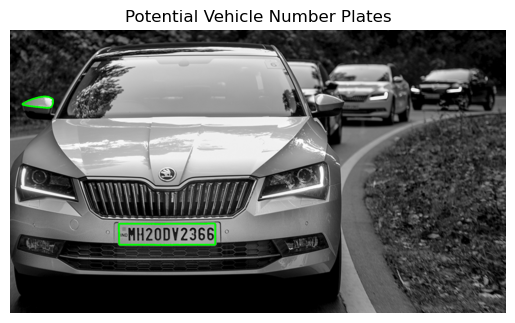

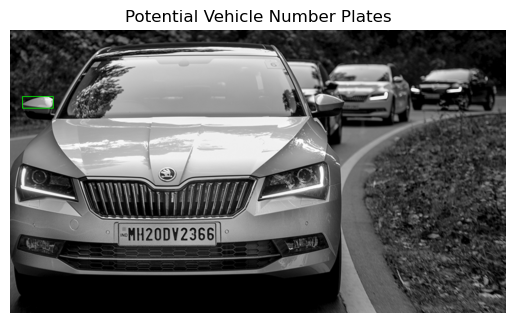

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


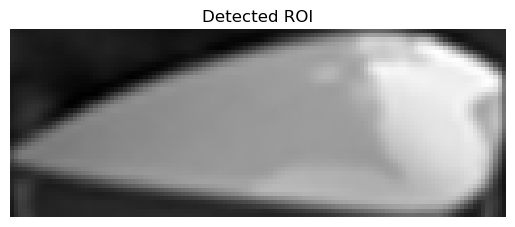

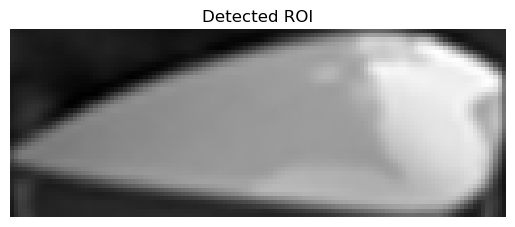

In [13]:
# example usage (for number plate with noisy background)
img_path = "numplate1.jpg"
find_number_plates(img_path)
find_number_plates_and_read_text(img_path)

For different images, you may need to adjust and experiment with the following:

1. The <b>lower threshold</b> and <b>upper threshold</b> specified in the `cv2.Canny()` function
2. The <b>range of areas</b> for detecting number plates